# GameTheory-14 : Theorie des Mecanismes et Principe de Revelation

**Navigation** : [<< 15-CooperativeGames](GameTheory-15-CooperativeGames.ipynb) | [Index](README.md) | [17-MultiAgent-RL >>](GameTheory-17-MultiAgent-RL.ipynb)

**Side tracks** : [16b-Lean-SocialChoice](GameTheory-16b-Lean-SocialChoice.ipynb) | [16c-SocialChoice-Python](GameTheory-16c-SocialChoice-Python.ipynb)

## Concevoir des Regles pour des Agents Strategiques

La **theorie des mecanismes** (mechanism design) est la "theorie des jeux inversee" : au lieu d'analyser un jeu donne, on **concoit** des regles pour atteindre un objectif.

**Objectifs pedagogiques** :
- Comprendre le principe de revelation
- Maitriser les notions de compatibilite incitative et rationalite individuelle
- Implementer le mecanisme VCG (Vickrey-Clarke-Groves)
- Appliquer a la conception d'encheres et de marches

**Prerequis** : Notebooks 1-13, notamment 10-BayesianGames

**Duree estimee** : 65 minutes

---

## 1. Introduction a la Conception de Mecanismes

### 1.1 Le probleme fondamental

Un **designer** (concepteur) veut implementer une fonction sociale $f(\theta)$ ou $\theta = (\theta_1, ..., \theta_n)$ sont les **types** (informations privees) des agents.

**Probleme** : Les agents connaissent leur type $\theta_i$, mais le designer ne le connait pas directement.

### 1.2 Elements d'un mecanisme

- **Messages** $M_i$ : ensemble des actions possibles pour l'agent $i$
- **Fonction de resultat** $g: M \to X$ : associe un resultat aux messages
- **Equilibre** : concept de solution (Nash, strategie dominante, etc.)

### 1.3 Exemples classiques

| Contexte | Objectif | Mecanisme |
|----------|----------|----------|
| **Encheres** | Maximiser revenu ou efficacite | Vickrey, encheres anglaises |
| **Biens publics** | Financement efficient | Mecanisme de Clarke |
| **Appariement** | Stabilite | Gale-Shapley |
| **Vote** | Agregation des preferences | Differentes regles electorales |

In [1]:
# Installation des dependances
import subprocess
import sys

packages = ['numpy', 'matplotlib', 'scipy']
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Callable, Optional
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
import itertools

print("Imports reussis")

Imports reussis


## 2. Le Principe de Revelation

### 2.1 Mecanismes directs et indirects

- **Mecanisme indirect** : les agents envoient des messages arbitraires
- **Mecanisme direct** : les agents reportent leur type (revelation)

### 2.2 Theoreme de revelation

**Theoreme (Gibbard, 1973; Myerson, 1979)** : Pour tout mecanisme indirect qui implemente $f$ en equilibre, il existe un mecanisme direct ou :
1. Chaque agent reporte son type
2. Dire la verite est un equilibre
3. Le resultat est le meme que dans le mecanisme original

### 2.3 Implications

On peut se restreindre aux mecanismes directs **incitatifs** (truthful) sans perte de generalite.

In [ ]:
@dataclass
class Agent:
    """Agent avec un type (valuation privee)."""
    id: int
    true_type: float  # Valuation reelle
    
    def utility(self, allocation: float, payment: float) -> float:
        """Utilite = valuation * allocation - paiement."""
        return self.true_type * allocation - payment


class Mechanism(ABC):
    """Classe abstraite pour un mecanisme."""
    
    @abstractmethod
    def allocate(self, reports: List[float]) -> List[float]:
        """Determine l'allocation basee sur les reports."""
        pass
    
    @abstractmethod
    def compute_payments(self, reports: List[float], 
                        allocations: List[float]) -> List[float]:
        """Determine les paiements."""
        pass
    
    def run(self, reports: List[float]) -> Tuple[List[float], List[float]]:
        """Execute le mecanisme."""
        allocations = self.allocate(reports)
        payments = self.compute_payments(reports, allocations)
        return allocations, payments
    
    def is_ic(self, agents: List[Agent], epsilon: float = 0.01) -> bool:
        """
        Verifie la compatibilite incitative (IC) en strategie dominante.
        
        IC: Pour tout agent, dire la verite est optimal quel que soit
        ce que les autres disent.
        """
        for i, agent in enumerate(agents):
            # Tester avec differents reports des autres
            other_reports_samples = [
                [a.true_type for a in agents if a.id != agent.id],
                [0.0] * (len(agents) - 1),
                [100.0] * (len(agents) - 1)
            ]
            
            for other_reports in other_reports_samples:
                # Utilite en disant la verite
                truth_reports = other_reports.copy()
                truth_reports.insert(i, agent.true_type)
                alloc_truth, pay_truth = self.run(truth_reports)
                u_truth = agent.utility(alloc_truth[i], pay_truth[i])
                
                # Tester des deviations
                for deviation in [0, agent.true_type * 0.5, agent.true_type * 1.5, agent.true_type * 2]:
                    lie_reports = other_reports.copy()
                    lie_reports.insert(i, deviation)
                    alloc_lie, pay_lie = self.run(lie_reports)
                    u_lie = agent.utility(alloc_lie[i], pay_lie[i])
                    
                    if u_lie > u_truth + epsilon:
                        return False
        return True
    
    def is_ir(self, agents: List[Agent]) -> bool:
        """
        Verifie la rationalite individuelle (IR).
        
        IR: Tout agent a une utilite non-negative en participapant.
        """
        reports = [a.true_type for a in agents]
        allocations, payments = self.run(reports)
        
        for i, agent in enumerate(agents):
            if agent.utility(allocations[i], payments[i]) < 0:
                return False
        return True


print("Classes de base definies")

Classes de base definies


## 3. Encheres : Premier et Second Prix

### 3.1 Enchere au premier prix (First-Price Auction)

- Le plus offrant gagne et paie son offre
- **Non incitatif** : les agents sous-encherissent strategiquement
- Equilibre : $b(v) = \frac{n-1}{n} v$ pour $n$ encherisseurs avec valuations uniformes

### 3.2 Enchere au second prix (Vickrey, 1961)

- Le plus offrant gagne mais paie la **deuxieme plus haute offre**
- **Incitatif en strategie dominante** : encherir sa vraie valuation est optimal

### 3.3 Theoreme d'equivalence des revenus

Sous certaines conditions (valuations privees independantes, neutralite au risque), tous les formats d'encheres generent le meme revenu espere.

In [3]:
class FirstPriceAuction(Mechanism):
    """Enchere au premier prix : le gagnant paie son offre."""
    
    def allocate(self, reports: List[float]) -> List[float]:
        """Le plus offrant gagne (allocation = 1)."""
        n = len(reports)
        allocations = [0.0] * n
        winner = int(np.argmax(reports))
        allocations[winner] = 1.0
        return allocations
    
    def compute_payments(self, reports: List[float], 
                        allocations: List[float]) -> List[float]:
        """Le gagnant paie son offre."""
        payments = [0.0] * len(reports)
        for i, alloc in enumerate(allocations):
            if alloc > 0:
                payments[i] = reports[i]
        return payments


class SecondPriceAuction(Mechanism):
    """Enchere au second prix (Vickrey) : le gagnant paie la 2e offre."""
    
    def allocate(self, reports: List[float]) -> List[float]:
        n = len(reports)
        allocations = [0.0] * n
        winner = int(np.argmax(reports))
        allocations[winner] = 1.0
        return allocations
    
    def compute_payments(self, reports: List[float], 
                        allocations: List[float]) -> List[float]:
        """Le gagnant paie la deuxieme plus haute offre."""
        payments = [0.0] * len(reports)
        sorted_reports = sorted(reports, reverse=True)
        second_price = sorted_reports[1] if len(sorted_reports) > 1 else 0
        
        for i, alloc in enumerate(allocations):
            if alloc > 0:
                payments[i] = second_price
        return payments


# Demonstration
print("Comparaison : Enchere premier prix vs second prix")
print("="*60)

agents = [
    Agent(0, 100),  # Valuation 100
    Agent(1, 80),   # Valuation 80
    Agent(2, 60)    # Valuation 60
]

fpa = FirstPriceAuction()
spa = SecondPriceAuction()

# Avec reports veridiques
true_reports = [a.true_type for a in agents]

print(f"\nValuations vraies: {true_reports}")

print("\n--- Enchere au premier prix ---")
alloc_fpa, pay_fpa = fpa.run(true_reports)
print(f"Allocations: {alloc_fpa}")
print(f"Paiements: {pay_fpa}")
print(f"Utilites: {[a.utility(alloc_fpa[i], pay_fpa[i]) for i, a in enumerate(agents)]}")

print("\n--- Enchere au second prix ---")
alloc_spa, pay_spa = spa.run(true_reports)
print(f"Allocations: {alloc_spa}")
print(f"Paiements: {pay_spa}")
print(f"Utilites: {[a.utility(alloc_spa[i], pay_spa[i]) for i, a in enumerate(agents)]}")

print(f"\nIC (second prix): {spa.is_ic(agents)}")
print(f"IR (second prix): {spa.is_ir(agents)}")

Comparaison : Enchere premier prix vs second prix

Valuations vraies: [100, 80, 60]

--- Enchere au premier prix ---
Allocations: [1.0, 0.0, 0.0]
Paiements: [100, 0.0, 0.0]
Utilites: [0.0, 0.0, 0.0]

--- Enchere au second prix ---
Allocations: [1.0, 0.0, 0.0]
Paiements: [80, 0.0, 0.0]
Utilites: [20.0, 0.0, 0.0]

IC (second prix): True
IR (second prix): True


In [4]:
# Demonstration de l'incitativite de Vickrey
print("\nIncitativite de l'enchere au second prix")
print("="*60)

# Agent 0 (valuation = 100) considere differentes strategies
agent0 = agents[0]
other_bids = [80, 60]  # Offres des autres (veridiques)

strategies = [0, 50, 79, 80, 81, 100, 120, 150]
results = []

for bid in strategies:
    reports = [bid] + other_bids
    alloc, pay = spa.run(reports)
    utility = agent0.utility(alloc[0], pay[0])
    results.append((bid, alloc[0], pay[0], utility))

print(f"\nAgent 0 (valuation = 100) vs offres adverses [80, 60]")
print(f"\n{'Offre':<10} {'Gagne?':<10} {'Paie':<10} {'Utilite':<10}")
print("-"*40)
for bid, alloc, pay, utility in results:
    gagne = "Oui" if alloc > 0 else "Non"
    print(f"{bid:<10} {gagne:<10} {pay:<10.0f} {utility:<10.0f}")

print(f"\n=> Utilite maximale ({max(r[3] for r in results):.0f}) atteinte en encherissant la vraie valeur (100)")


Incitativite de l'enchere au second prix

Agent 0 (valuation = 100) vs offres adverses [80, 60]

Offre      Gagne?     Paie       Utilite   
----------------------------------------
0          Non        0          0         
50         Non        0          0         
79         Non        0          0         
80         Oui        80         20        
81         Oui        80         20        
100        Oui        80         20        
120        Oui        80         20        
150        Oui        80         20        

=> Utilite maximale (20) atteinte en encherissant la vraie valeur (100)



Simulation : Equivalence des revenus (1er prix vs 2nd prix)

Resultats sur 10000 encheres avec 3 encherisseurs:
  Revenu moyen (1er prix): 49.92
  Revenu moyen (2nd prix): 50.01
  Difference: 0.09
  Revenu theorique: 50.00


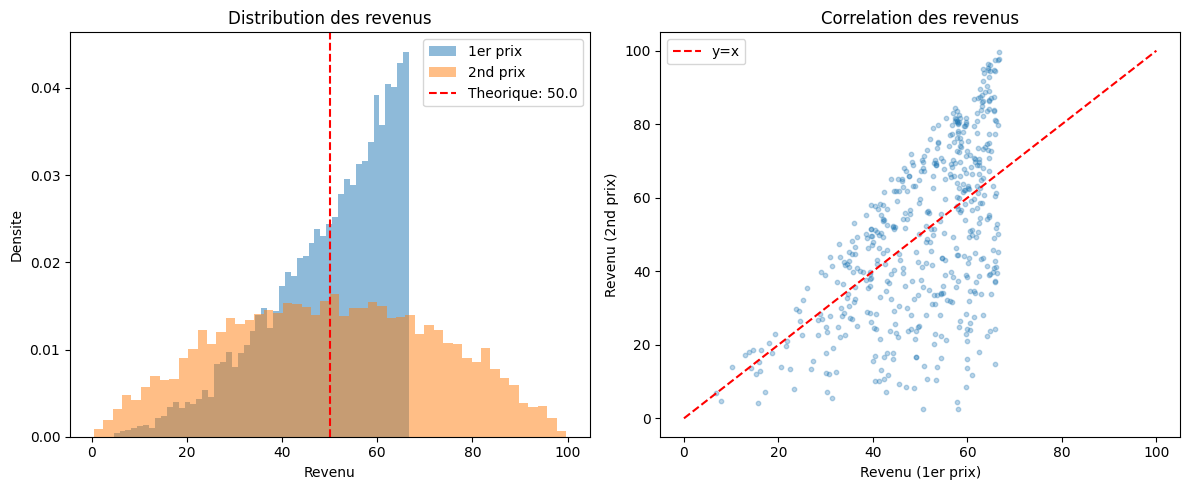

In [5]:
# Simulation : equivalence des revenus
print("\nSimulation : Equivalence des revenus (1er prix vs 2nd prix)")
print("="*60)

np.random.seed(42)
n_simulations = 10000
n_bidders = 3

revenues_fpa = []
revenues_spa = []

for _ in range(n_simulations):
    # Valuations uniformes [0, 100]
    valuations = np.random.uniform(0, 100, n_bidders)
    
    # Second prix : encheres veridiques
    _, pay_spa = spa.run(list(valuations))
    revenues_spa.append(sum(pay_spa))
    
    # Premier prix : equilibre b(v) = (n-1)/n * v
    bids_fpa = valuations * (n_bidders - 1) / n_bidders
    _, pay_fpa = fpa.run(list(bids_fpa))
    revenues_fpa.append(sum(pay_fpa))

print(f"\nResultats sur {n_simulations} encheres avec {n_bidders} encherisseurs:")
print(f"  Revenu moyen (1er prix): {np.mean(revenues_fpa):.2f}")
print(f"  Revenu moyen (2nd prix): {np.mean(revenues_spa):.2f}")
print(f"  Difference: {abs(np.mean(revenues_fpa) - np.mean(revenues_spa)):.2f}")

# Revenu theorique : E[2eme max sur n uniformes [0,100]] = 100 * (n-1)/(n+1)
theoretical_revenue = 100 * (n_bidders - 1) / (n_bidders + 1)
print(f"  Revenu theorique: {theoretical_revenue:.2f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.hist(revenues_fpa, bins=50, alpha=0.5, label='1er prix', density=True)
ax1.hist(revenues_spa, bins=50, alpha=0.5, label='2nd prix', density=True)
ax1.axvline(theoretical_revenue, color='red', linestyle='--', label=f'Theorique: {theoretical_revenue:.1f}')
ax1.set_xlabel('Revenu')
ax1.set_ylabel('Densite')
ax1.set_title('Distribution des revenus')
ax1.legend()

ax2 = axes[1]
ax2.scatter(revenues_fpa[:500], revenues_spa[:500], alpha=0.3, s=10)
ax2.plot([0, 100], [0, 100], 'r--', label='y=x')
ax2.set_xlabel('Revenu (1er prix)')
ax2.set_ylabel('Revenu (2nd prix)')
ax2.set_title('Correlation des revenus')
ax2.legend()

plt.tight_layout()
plt.savefig('auction_revenue_equivalence.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Mecanisme VCG (Vickrey-Clarke-Groves)

### 4.1 Generalisation de Vickrey

Le mecanisme VCG generalise l'enchere de Vickrey a tout probleme d'allocation.

**Structure** :
1. **Allocation efficace** : maximise le bien-etre social $\sum_i v_i(x, \theta_i)$
2. **Paiement** : l'agent $i$ paie l'**externalite** qu'il impose aux autres

### 4.2 Formule de paiement VCG

$$p_i = \sum_{j \neq i} v_j(x^*_{-i}, \theta_j) - \sum_{j \neq i} v_j(x^*, \theta_j)$$

Ou :
- $x^*$ est l'allocation optimale avec tous les agents
- $x^*_{-i}$ est l'allocation optimale sans l'agent $i$

### 4.3 Proprietes

- **IC** : Dire la verite est une strategie dominante
- **Efficacite** : L'allocation maximise le bien-etre social
- **IR** (ex-post) : Utilite non-negative pour tout agent

In [ ]:
class VCGAuction(Mechanism):
    """
    Mecanisme VCG pour une enchere multi-objets.
    
    Chaque agent a une valuation pour chaque objet.
    Allocation: chaque objet va a l'agent qui le valorise le plus.
    Paiement: externalite imposee aux autres.
    """
    
    def __init__(self, n_items: int):
        self.n_items = n_items
    
    def allocate(self, valuations: List[List[float]]) -> List[List[float]]:
        """
        valuations[i][j] = valuation de l'agent i pour l'objet j.
        
        Retourne allocations[i][j] = 1 si agent i recoit objet j.
        """
        n_agents = len(valuations)
        allocations = [[0.0] * self.n_items for _ in range(n_agents)]
        
        for j in range(self.n_items):
            # Objet j va au plus offrant
            bids_for_j = [valuations[i][j] for i in range(n_agents)]
            winner = int(np.argmax(bids_for_j))
            allocations[winner][j] = 1.0
        
        return allocations
    
    def compute_social_welfare(self, valuations: List[List[float]], 
                               allocations: List[List[float]]) -> float:
        """Calcule le bien-etre social total."""
        welfare = 0.0
        for i, alloc in enumerate(allocations):
            for j, a in enumerate(alloc):
                welfare += a * valuations[i][j]
        return welfare
    
    def compute_payments(self, valuations: List[List[float]], 
                        allocations: List[List[float]]) -> List[float]:
        """
        Paiement VCG : externalite imposee aux autres.
        
        p_i = SW_{-i}(sans i) - SW_{-i}(avec i)
        """
        n_agents = len(valuations)
        payments = [0.0] * n_agents
        
        # Bien-etre des autres avec allocation actuelle
        for i in range(n_agents):
            # SW des autres avec i present
            sw_others_with_i = 0.0
            for j_agent in range(n_agents):
                if j_agent != i:
                    for j_item in range(self.n_items):
                        sw_others_with_i += allocations[j_agent][j_item] * valuations[j_agent][j_item]
            
            # SW des autres si i absent (recalculer l'allocation optimale)
            valuations_without_i = [v for k, v in enumerate(valuations) if k != i]
            if valuations_without_i:
                alloc_without_i = self._allocate_subset(valuations_without_i)
                sw_others_without_i = self.compute_social_welfare(
                    valuations_without_i, alloc_without_i
                )
            else:
                sw_others_without_i = 0.0
            
            # Paiement = externalite negative
            payments[i] = sw_others_without_i - sw_others_with_i
        
        return payments
    
    def _allocate_subset(self, valuations: List[List[float]]) -> List[List[float]]:
        """Allocation pour un sous-ensemble d'agents."""
        n_agents = len(valuations)
        allocations = [[0.0] * self.n_items for _ in range(n_agents)]
        
        for j in range(self.n_items):
            bids_for_j = [valuations[i][j] for i in range(n_agents)]
            winner = int(np.argmax(bids_for_j))
            allocations[winner][j] = 1.0
        
        return allocations
    
    def run(self, valuations: List[List[float]]
           ) -> Tuple[List[List[float]], List[float]]:
        """Execute le mecanisme VCG."""
        allocations = self.allocate(valuations)
        payments = self.compute_payments(valuations, allocations)
        return allocations, payments


# Exemple : encheres multi-objets
print("Mecanisme VCG : Enchere multi-objets")
print("="*60)

# 3 agents, 2 objets
# valuations[i][j] = valuation agent i pour objet j
valuations = [
    [50, 30],  # Agent 0
    [40, 60],  # Agent 1
    [35, 25]   # Agent 2
]

vcg = VCGAuction(n_items=2)
allocations, payments = vcg.run(valuations)

print(f"\nValuations:")
for i, v in enumerate(valuations):
    print(f"  Agent {i}: Objet A = {v[0]}, Objet B = {v[1]}")

print(f"\nAllocations VCG:")
for i, alloc in enumerate(allocations):
    items = [f"Objet {'AB'[j]}" for j, a in enumerate(alloc) if a > 0]
    print(f"  Agent {i}: {items if items else 'Rien'}")

print(f"\nPaiements VCG:")
for i, pay in enumerate(payments):
    print(f"  Agent {i}: {pay:.2f}")

print(f"\nUtilites:")
for i in range(len(valuations)):
    value = sum(allocations[i][j] * valuations[i][j] for j in range(2))
    utility = value - payments[i]
    print(f"  Agent {i}: valeur={value:.0f}, paiement={payments[i]:.0f}, utilite={utility:.0f}")

Mecanisme VCG : Enchere multi-objets

Valuations:
  Agent 0: Objet A = 50, Objet B = 30
  Agent 1: Objet A = 40, Objet B = 60
  Agent 2: Objet A = 35, Objet B = 25

Allocations VCG:
  Agent 0: ['Objet A']
  Agent 1: ['Objet B']
  Agent 2: Rien

Paiements VCG:
  Agent 0: 40.00
  Agent 1: 30.00
  Agent 2: 0.00

Utilites:
  Agent 0: valeur=50, paiement=40, utilite=10
  Agent 1: valeur=60, paiement=30, utilite=30
  Agent 2: valeur=0, paiement=0, utilite=0


In [7]:
# Verification de l'incitativite VCG
print("\nVerification de l'incitativite VCG")
print("="*60)

# Agent 0 (valuations [50, 30]) considere mentir
true_val_0 = [50, 30]
lie_strategies = [
    [50, 30],   # Verite
    [60, 40],   # Sur-encherir
    [35, 20],   # Sous-encherir
    [50, 70],   # Sur-encherir sur B (qu'il veut moins)
]

print(f"\nAgent 0 (vraie valuation: {true_val_0})")
print(f"Autres agents: Agent 1 = [40, 60], Agent 2 = [35, 25]")
print(f"\n{'Report':<15} {'Allocation':<15} {'Paiement':<12} {'Utilite vraie':<15}")
print("-"*57)

for report in lie_strategies:
    # Construire les valuations avec le report de l'agent 0
    test_valuations = [report, [40, 60], [35, 25]]
    alloc, pay = vcg.run(test_valuations)
    
    # Utilite VRAIE (basee sur vraie valuation, pas le report)
    true_value = sum(alloc[0][j] * true_val_0[j] for j in range(2))
    true_utility = true_value - pay[0]
    
    items = "AB"[0] if alloc[0][0] > 0 else ""
    items += "AB"[1] if alloc[0][1] > 0 else ""
    
    print(f"{str(report):<15} {items if items else 'Rien':<15} {pay[0]:<12.0f} {true_utility:<15.0f}")

print(f"\n=> L'utilite est maximale en disant la verite (strategie dominante)")


Verification de l'incitativite VCG

Agent 0 (vraie valuation: [50, 30])
Autres agents: Agent 1 = [40, 60], Agent 2 = [35, 25]

Report          Allocation      Paiement     Utilite vraie  
---------------------------------------------------------
[50, 30]        A               40           10             
[60, 40]        A               40           10             
[35, 20]        Rien            0            0              
[50, 70]        AB              100          -20            

=> L'utilite est maximale en disant la verite (strategie dominante)


## 5. Algorithme de Gale-Shapley (Matching)

### 5.1 Probleme du mariage stable

- $n$ hommes et $n$ femmes avec des preferences strictes
- **Appariement stable** : aucune paire ne prefererait etre ensemble

### 5.2 Algorithme

1. Chaque homme propose a sa femme preferee non-encore rejetee
2. Chaque femme garde la meilleure proposition et rejette les autres
3. Repeter jusqu'a convergence

### 5.3 Proprietes

- **Stabilite** : L'appariement final est stable
- **Optimal pour les proposants** : Meilleur appariement stable pour les hommes
- **Strategie-proof** pour les proposants : Dire la verite est optimal

In [8]:
def gale_shapley(men_preferences: Dict[str, List[str]], 
                 women_preferences: Dict[str, List[str]]) -> Dict[str, str]:
    """
    Algorithme de Gale-Shapley (Deferred Acceptance).
    
    men_preferences[m] = liste ordonnee des femmes preferees par m
    women_preferences[w] = liste ordonnee des hommes preferes par w
    
    Retourne un dictionnaire {homme: femme}.
    """
    # Copie des preferences pour modification
    remaining_prefs = {m: list(prefs) for m, prefs in men_preferences.items()}
    
    # Etat courant
    free_men = list(men_preferences.keys())
    engaged = {}  # femme -> homme
    
    # Fonction pour comparer les preferences des femmes
    def prefers(woman, m1, m2):
        """Retourne True si woman prefere m1 a m2."""
        prefs = women_preferences[woman]
        return prefs.index(m1) < prefs.index(m2)
    
    iteration = 0
    while free_men:
        iteration += 1
        man = free_men[0]
        
        if not remaining_prefs[man]:
            # Plus personne a proposer
            free_men.pop(0)
            continue
        
        # L'homme propose a sa femme preferee restante
        woman = remaining_prefs[man].pop(0)
        
        if woman not in engaged:
            # Femme libre, accepte temporairement
            engaged[woman] = man
            free_men.pop(0)
        elif prefers(woman, man, engaged[woman]):
            # Femme prefere le nouveau, rejette l'ancien
            old_man = engaged[woman]
            engaged[woman] = man
            free_men.pop(0)
            free_men.append(old_man)
        # Sinon, la femme garde son fiance actuel (rejection implicite)
    
    # Inverser pour avoir homme -> femme
    matching = {m: w for w, m in engaged.items()}
    return matching


def is_stable_matching(matching: Dict[str, str],
                       men_prefs: Dict[str, List[str]],
                       women_prefs: Dict[str, List[str]]) -> bool:
    """
    Verifie si un appariement est stable.
    
    Un appariement est instable s'il existe un couple (m, w) qui n'est pas
    marie mais qui se prefere mutuellement a leurs partenaires actuels.
    """
    # Inverser le matching
    reverse_matching = {w: m for m, w in matching.items()}
    
    for m, w_current in matching.items():
        m_prefs = men_prefs[m]
        
        # Femmes que m prefere a sa partenaire actuelle
        better_women = m_prefs[:m_prefs.index(w_current)]
        
        for w in better_women:
            w_prefs = women_prefs[w]
            w_current_man = reverse_matching.get(w)
            
            # Si w prefere aussi m a son partenaire actuel
            if w_current_man is None or w_prefs.index(m) < w_prefs.index(w_current_man):
                return False  # Paire bloquante trouvee
    
    return True


# Exemple
print("Algorithme de Gale-Shapley (Matching Stable)")
print("="*60)

men_preferences = {
    'A': ['X', 'Y', 'Z'],
    'B': ['Y', 'X', 'Z'],
    'C': ['Y', 'Z', 'X']
}

women_preferences = {
    'X': ['B', 'A', 'C'],
    'Y': ['A', 'B', 'C'],
    'Z': ['A', 'B', 'C']
}

print("\nPreferences des hommes:")
for m, prefs in men_preferences.items():
    print(f"  {m}: {' > '.join(prefs)}")

print("\nPreferences des femmes:")
for w, prefs in women_preferences.items():
    print(f"  {w}: {' > '.join(prefs)}")

# Execution
matching = gale_shapley(men_preferences, women_preferences)

print(f"\nAppariement (hommes proposent):")
for m, w in sorted(matching.items()):
    print(f"  {m} <-> {w}")

print(f"\nStabilite: {is_stable_matching(matching, men_preferences, women_preferences)}")

Algorithme de Gale-Shapley (Matching Stable)

Preferences des hommes:
  A: X > Y > Z
  B: Y > X > Z
  C: Y > Z > X

Preferences des femmes:
  X: B > A > C
  Y: A > B > C
  Z: A > B > C

Appariement (hommes proposent):
  A <-> X
  B <-> Y
  C <-> Z

Stabilite: True


In [10]:
# Comparaison : hommes vs femmes proposent
print("Comparaison : Qui propose?")
print("="*60)

# Hommes proposent (deja calcule)
matching_men_propose = matching

# Femmes proposent (inverser les roles)
# gale_shapley retourne {proposeur: accepteur}
# Quand les femmes proposent: retourne {femme: homme}
matching_women_raw = gale_shapley(women_preferences, men_preferences)
# Inverser pour avoir {homme: femme}
matching_women_propose = {m: w for w, m in matching_women_raw.items()}

print(f"{'Homme':<8} {'Femme (H propose)':<20} {'Femme (F propose)'}")
print("-"*50)
for m in sorted(men_preferences.keys()):
    w1 = matching_men_propose.get(m, '-')
    w2 = matching_women_propose.get(m, '-')
    print(f"{m:<8} {w1:<20} {w2}")

# Calculer le rang moyen
def average_rank(matching, preferences):
    """
    Rang moyen du partenaire obtenu (1 = premier choix).
    matching: {agent: partenaire}
    preferences: {agent: [liste ordonnee de partenaires]}
    """
    total_rank = 0
    for agent, partner in matching.items():
        prefs = preferences[agent]
        rank = prefs.index(partner) + 1
        total_rank += rank
    return total_rank / len(matching)

print(f"Rang moyen des partenaires (1 = premier choix):")

# Hommes proposent: matching_men_propose = {homme: femme}
# Rang hommes: chaque homme obtient quelle femme dans son classement?
print(f"  Hommes proposent -> Rang moyen hommes: {average_rank(matching_men_propose, men_preferences):.2f}")
# Rang femmes: on inverse pour avoir {femme: homme} et utiliser women_preferences
matching_inv_men = {w: m for m, w in matching_men_propose.items()}
print(f"  Hommes proposent -> Rang moyen femmes: {average_rank(matching_inv_men, women_preferences):.2f}")

# Femmes proposent
if matching_women_propose:
    # matching_women_propose = {homme: femme}
    # Rang hommes: chaque homme obtient quelle femme dans son classement?
    print(f"  Femmes proposent -> Rang moyen hommes: {average_rank(matching_women_propose, men_preferences):.2f}")
    # Rang femmes: matching_women_raw = {femme: homme}
    print(f"  Femmes proposent -> Rang moyen femmes: {average_rank(matching_women_raw, women_preferences):.2f}")

print(f"=> Les proposants obtiennent un meilleur resultat!")

Comparaison : Qui propose?
Homme    Femme (H propose)    Femme (F propose)
--------------------------------------------------
A        X                    Y
B        Y                    X
C        Z                    Z
Rang moyen des partenaires (1 = premier choix):
  Hommes proposent -> Rang moyen hommes: 1.33
  Hommes proposent -> Rang moyen femmes: 2.33
  Femmes proposent -> Rang moyen hommes: 2.00
  Femmes proposent -> Rang moyen femmes: 1.67
=> Les proposants obtiennent un meilleur resultat!


## 6. Theoreme d'Impossibilite et Limites

### 6.1 Theoreme de Gibbard-Satterthwaite

Pour les fonctions de choix social (au moins 3 alternatives) :
- Si la fonction est **non-dictatoriale** et **surjective**
- Alors elle n'est **pas** implementable en strategie dominante

### 6.2 Implications

- Les mecanismes VCG sont l'exception (transferts monetaires)
- Sans paiements, l'incitativite est tres difficile
- Trade-off : efficacite vs budget-balance vs incitativite

### 6.3 Theoreme de Myerson-Satterthwaite

Pour l'echange bilatéral : impossible d'avoir simultanement :
- Efficacite (echange quand $v_{acheteur} > v_{vendeur}$)
- Incitativite
- Rationalite individuelle
- Budget balance (pas de subvention externe)

In [11]:
# Illustration : Probleme d'echange bilateral
print("Theoreme de Myerson-Satterthwaite : Echange Bilateral")
print("="*60)

class BilateralExchange:
    """
    Mecanisme d'echange entre un vendeur et un acheteur.
    
    Vendeur a valuation v_s (cout de renonciation)
    Acheteur a valuation v_b
    Echange efficient si v_b > v_s
    """
    
    def __init__(self, mechanism_type: str = 'double_auction'):
        self.mechanism_type = mechanism_type
    
    def run(self, v_seller: float, v_buyer: float) -> Tuple[bool, float, float]:
        """
        Execute le mecanisme.
        
        Retourne (echange_a_lieu, paiement_vendeur_recoit, paiement_acheteur_paie).
        """
        if self.mechanism_type == 'double_auction':
            # Prix = moyenne des reports
            # Echange si offre acheteur >= demande vendeur
            if v_buyer >= v_seller:
                price = (v_buyer + v_seller) / 2
                return True, price, price
            return False, 0, 0
        
        elif self.mechanism_type == 'vcg_like':
            # Tentative VCG (non budget-balanced)
            # Echange efficient
            if v_buyer >= v_seller:
                # Acheteur paie la valuation du vendeur
                # Vendeur recoit la valuation de l'acheteur
                return True, v_buyer, v_seller
            return False, 0, 0
        
        return False, 0, 0
    
    def is_ic(self, v_s_true: float, v_b_true: float) -> Tuple[bool, bool]:
        """
        Verifie l'incitativite pour vendeur et acheteur.
        """
        # Test pour le vendeur
        ic_seller = True
        trade_true, pay_s_true, _ = self.run(v_s_true, v_b_true)
        utility_s_true = pay_s_true - (v_s_true if trade_true else 0)
        
        for v_s_lie in [0, v_s_true * 0.5, v_s_true * 1.5, v_s_true * 2, 100]:
            trade_lie, pay_s_lie, _ = self.run(v_s_lie, v_b_true)
            utility_s_lie = pay_s_lie - (v_s_true if trade_lie else 0)
            if utility_s_lie > utility_s_true + 0.01:
                ic_seller = False
                break
        
        # Test pour l'acheteur
        ic_buyer = True
        trade_true, _, pay_b_true = self.run(v_s_true, v_b_true)
        utility_b_true = (v_b_true if trade_true else 0) - pay_b_true
        
        for v_b_lie in [0, v_b_true * 0.5, v_b_true * 1.5, v_b_true * 2, 100]:
            trade_lie, _, pay_b_lie = self.run(v_s_true, v_b_lie)
            utility_b_lie = (v_b_true if trade_lie else 0) - pay_b_lie
            if utility_b_lie > utility_b_true + 0.01:
                ic_buyer = False
                break
        
        return ic_seller, ic_buyer


# Comparaison des mecanismes
print("\nScenario: Vendeur (v=30), Acheteur (v=50)")
print("Echange efficient: Oui (50 > 30)\n")

v_s, v_b = 30, 50

for mech_type in ['double_auction', 'vcg_like']:
    exchange = BilateralExchange(mech_type)
    trade, pay_s, pay_b = exchange.run(v_s, v_b)
    
    print(f"Mecanisme: {mech_type}")
    print(f"  Echange: {trade}")
    if trade:
        print(f"  Vendeur recoit: {pay_s:.2f}, Acheteur paie: {pay_b:.2f}")
        print(f"  Budget balance: {abs(pay_s - pay_b) < 0.01}")
        utility_s = pay_s - v_s
        utility_b = v_b - pay_b
        print(f"  Utilite vendeur: {utility_s:.2f}, Utilite acheteur: {utility_b:.2f}")
    
    ic_s, ic_b = exchange.is_ic(v_s, v_b)
    print(f"  IC vendeur: {ic_s}, IC acheteur: {ic_b}")
    print()

Theoreme de Myerson-Satterthwaite : Echange Bilateral

Scenario: Vendeur (v=30), Acheteur (v=50)
Echange efficient: Oui (50 > 30)

Mecanisme: double_auction
  Echange: True
  Vendeur recoit: 40.00, Acheteur paie: 40.00
  Budget balance: True
  Utilite vendeur: 10.00, Utilite acheteur: 10.00
  IC vendeur: False, IC acheteur: True

Mecanisme: vcg_like
  Echange: True
  Vendeur recoit: 50.00, Acheteur paie: 30.00
  Budget balance: False
  Utilite vendeur: 20.00, Utilite acheteur: 20.00
  IC vendeur: True, IC acheteur: True



## 7. Exercices

### Exercice 1 : Enchere All-Pay

Implementez une enchere "all-pay" ou tous les encherisseurs paient leur offre (meme les perdants). Montrez que ce n'est pas incitatif.

### Exercice 2 : VCG pour biens publics

Implementez le mecanisme de Clarke pour le financement d'un bien public.

### Exercice 3 : Manipulation dans Gale-Shapley

Montrez qu'une femme peut ameliorer son resultat en mentant sur ses preferences.

### Exercice 4 : Enchere combinatoire

Etendez le VCG aux encheres ou les agents ont des valuations pour des combinaisons d'objets (complementarites/substituts).

In [12]:
# Espace pour les exercices

# Exercice 1 : Enchere All-Pay
class AllPayAuction(Mechanism):
    """Enchere all-pay : tous paient leur offre."""
    
    def allocate(self, reports: List[float]) -> List[float]:
        n = len(reports)
        allocations = [0.0] * n
        winner = int(np.argmax(reports))
        allocations[winner] = 1.0
        return allocations
    
    def compute_payments(self, reports: List[float], 
                        allocations: List[float]) -> List[float]:
        """Tout le monde paie son offre."""
        return list(reports)


# Test incitativite
print("Exercice 1 : Enchere All-Pay")
print("="*50)

apa = AllPayAuction()
agents_test = [Agent(0, 100), Agent(1, 80), Agent(2, 60)]

print(f"\nIC: {apa.is_ic(agents_test)}")
print("-> All-pay n'est pas incitatif (on veut encherir juste au-dessus de l'adversaire)")

Exercice 1 : Enchere All-Pay

IC: False
-> All-pay n'est pas incitatif (on veut encherir juste au-dessus de l'adversaire)


## 8. Resume et Points Cles

### Ce que nous avons appris

1. **Principe de revelation** : on peut se limiter aux mecanismes directs
2. **Incitativite (IC)** : dire la verite est optimal
3. **Rationalite individuelle (IR)** : participation volontaire
4. **VCG** : mecanisme general efficient et incitatif
5. **Gale-Shapley** : matching stable en temps polynomial

### Formules et concepts cles

| Mecanisme | Allocation | Paiement | IC? |
|-----------|------------|----------|-----|
| 1er prix | Max bid | Son bid | Non |
| 2nd prix (Vickrey) | Max bid | 2e bid | Oui |
| VCG | Maximise SW | Externalite | Oui |
| Gale-Shapley | Stable | - | Pour proposants |

### Limites fondamentales

- **Gibbard-Satterthwaite** : sans paiements, pas d'incitativite generale
- **Myerson-Satterthwaite** : efficacite + IC + IR + budget-balance impossible
- **Trade-offs** : toujours des compromis a faire

---

**Notebook suivant** : [GameTheory-15-MultiAgent-RL](GameTheory-15-MultiAgent-RL.ipynb) - Apprentissage multi-agent et self-play